In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *
import glob
#import scipy as sp

import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/home/bursik/anaconda3/envs/conda_pcsaft/lib/python3.10/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

# Local DFT Implementation

In [2]:
components = ['hexane']#, 'pentane']
composition = np.array([0.3, 0.7]) *MOL
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [3]:
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')
func = PcSaftFunctional(params)
func_hs = (params)

In [4]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|298.15 K|8.23411069162512  mol/m³|
|phase 2|298.15 K|7.537249518083163 kmol/m³|


In [5]:
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=True)#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another
# solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=10, max_iter=50, beta=0.05)# # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit, local_flag=True)
#print(f'max density = {max(interface.density/MOL*METER**3)}' ) 
density_init = interface.density

Version with total moles


In [6]:
interface.local_functional_derivative[0]-interface.local_functional_derivative_v2[0]
interface.functional_derivative

thread '<unnamed>' panicked at 'ndarray: index (0, 1024) is out of bounds for array of shape [3, 1024]', /home/bursik/promotion/code/feos/feos-dft/src/convolver/mod.rs:163:17
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: ndarray: index (0, 1024) is out of bounds for array of shape [3, 1024]

In [ ]:
# solve DFT'
# interface.solve(solver, debug=True)

Version with total moles
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 4.203830e-4 | 0.01
Picard iteration     |    2 | 3.995227e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 3.995227e-4 | 0.01
Picard iteration     |    2 | 3.797732e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 3.797732e-4 | 0.01
Picard iteration     |    2 | 3.610809e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 3.610809e-4 | 0.01
Picard iteration     |    2 | 3.433932e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 3.433932e-4 | 0.01
Picard iteration     |    2 | 3.266585e-4 | 0.01
solver               | iter | residual 
-------------------------

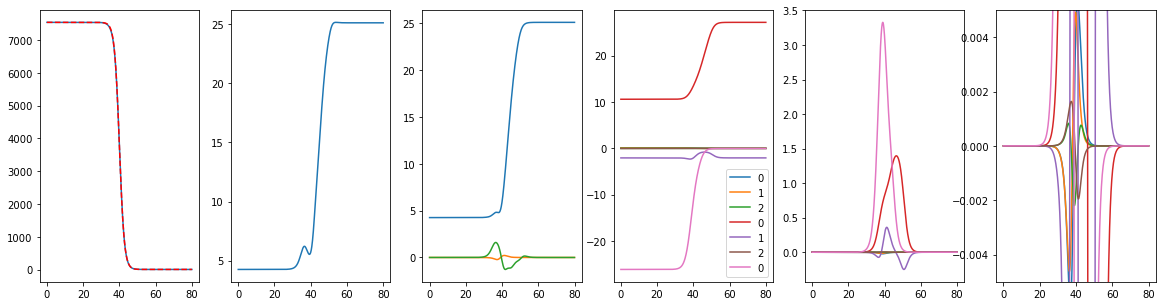

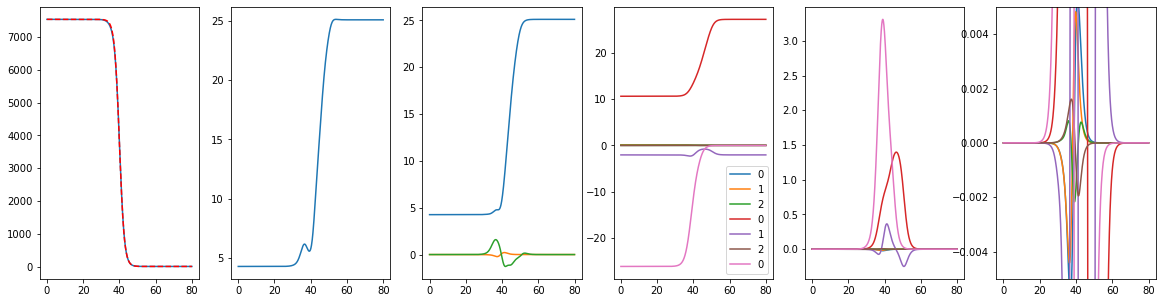

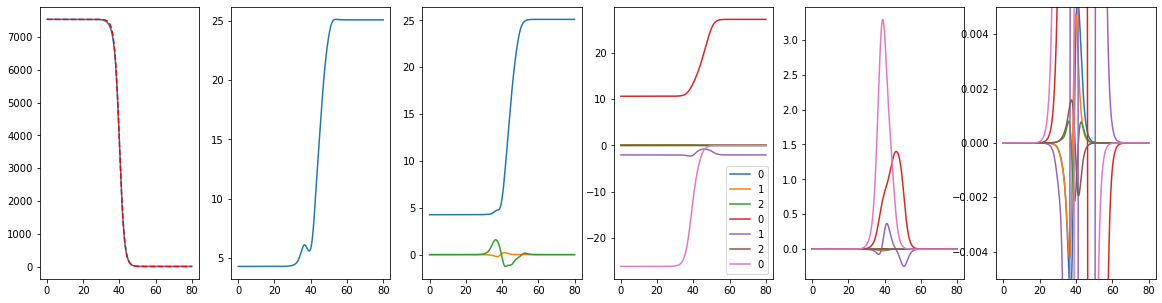

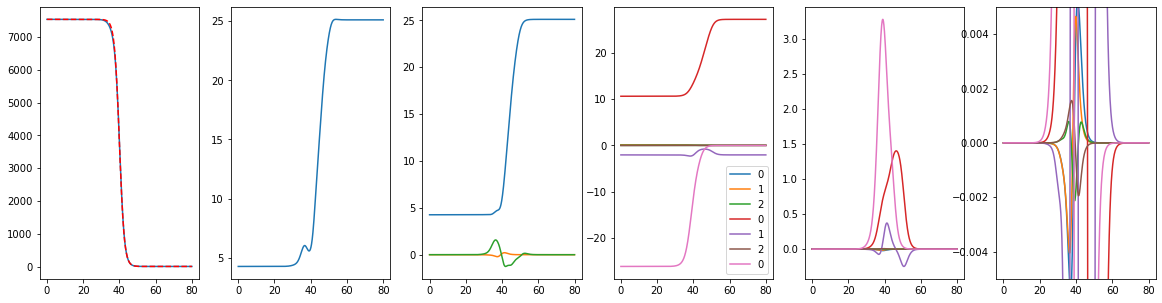

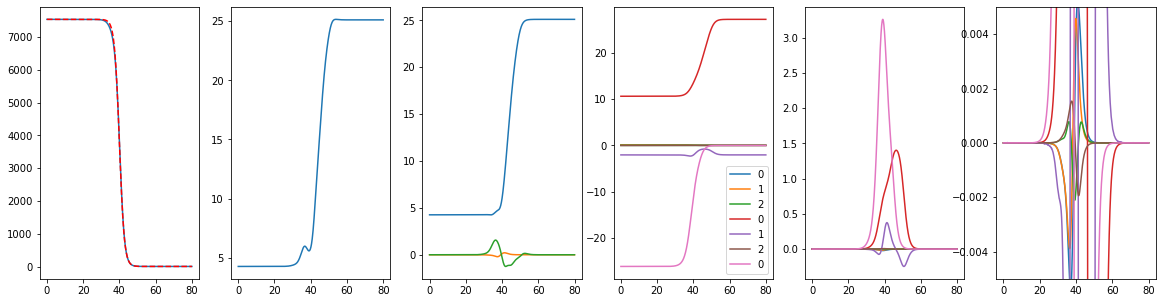

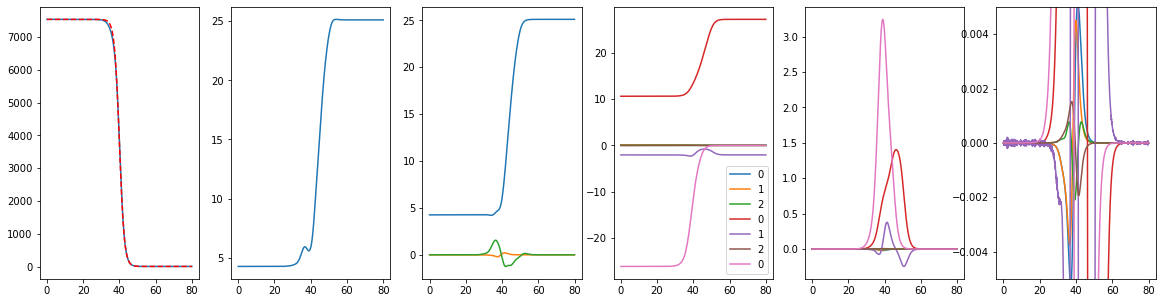

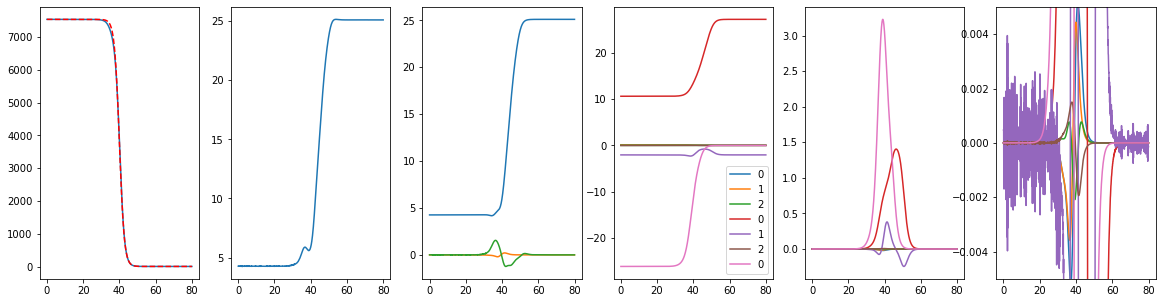

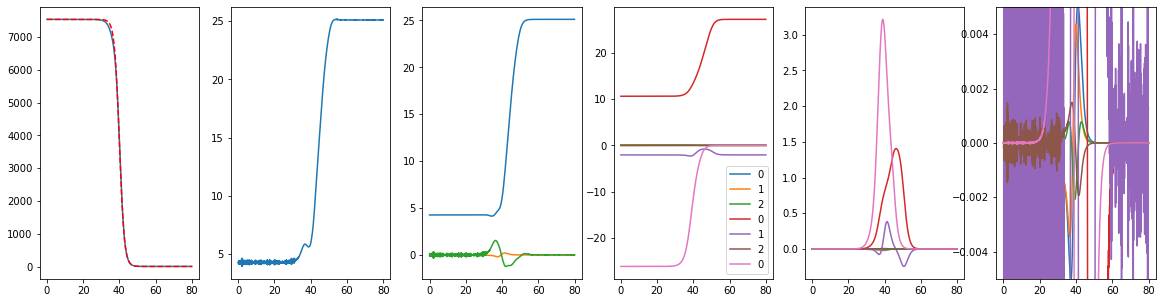

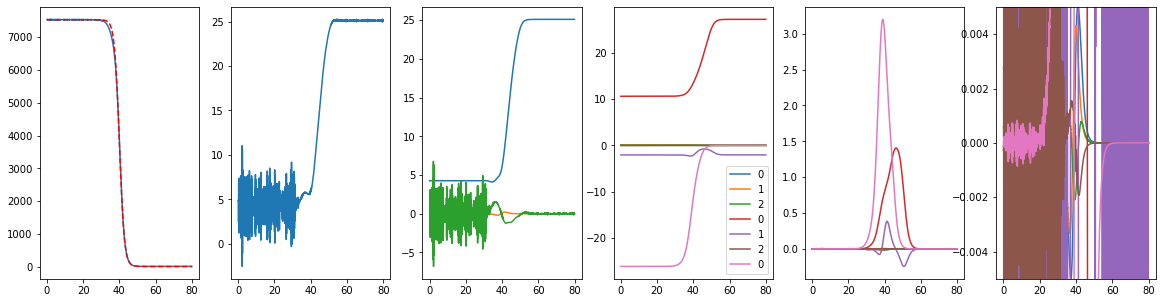

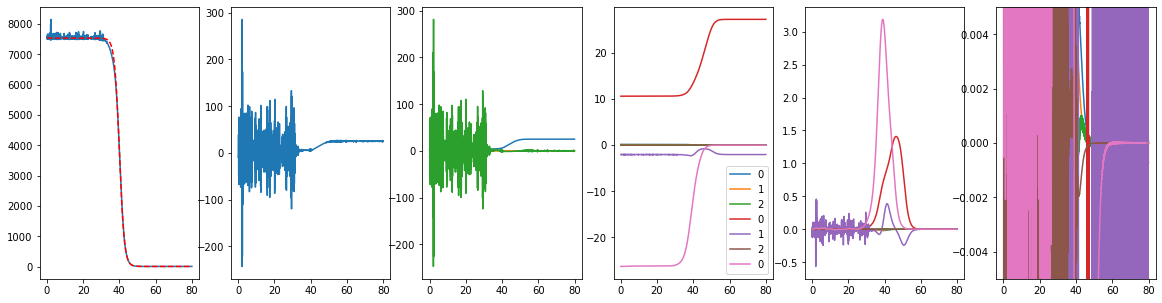

In [9]:
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=2, log=False )#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another
# solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=50, max_iter=5, beta=0.02)# # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit, local_flag=True)
density_init = interface.density
i = 0
while i < 10:
    interface.solve(solver, debug=True)    
    fig, axs = plt.subplots(1, 6, figsize=(20, 5), facecolor='w', edgecolor='k')
    axs[0].plot(interface.z / ANGSTROM, (interface.density/MOL*METER**3)[0,:])
    axs[0].plot(interface.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')
    # axs[0].set_ylim([7537, 7538])
    
    # axs[0].set_ylim([(interface.density/MOL*METER**3)[0,0]-0.01, (interface.density/MOL*METER**3)[0,0]+0.01])
    # axs[0].set_xlim([0, 20])

    axs[1].plot(interface.z / ANGSTROM, (interface.functional_derivative)[0,:])
    #axs[1].set_ylim([4.2605, 4.26075])

    
    for filename in glob.glob('fd*.npy'):
        data = np.load(filename)    
        axs[2].plot(interface.z / ANGSTROM, (data)[0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[0][0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[1][0,:])
    # axs[2].plot(interface.z / ANGSTROM, (interface.weighted_densities)[2][0,:])
    # axs[2].set_ylim([-0.01,.01])    
    
    for filename in glob.glob('*_firstpd.npy'):
        # print(filename)
        data = np.load(filename)   
        for j in range(data.shape[0]):
            axs[3].plot(interface.z / ANGSTROM, (data)[j,:], label=f'{j}')
    # axs[3].plot(interface.z / ANGSTROM, (data)[1,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[2,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[3,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[4,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[5,:])
    # axs[3].set_ylim([-0.000001,.000001])
    axs[3].legend()
    
    for filename in glob.glob('*_grad_fpd.npy'):
        data = np.load(filename)
        for j in range(data.shape[0]):
            axs[4].plot(interface.z / ANGSTROM, (data)[j,:])
            # print(i)
        
    for filename in glob.glob('*_lapl_fpd.npy'):
        data = np.load(filename)    
        for j in range(data.shape[0]):
            axs[5].plot(interface.z / ANGSTROM, (data)[j,:])
            # print(i)
            
    axs[5].set_ylim([-0.005,.005])
    
    # print(data)
    fig.show()

    i = i + 1

Version with total moles
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 4.203830e-4 | 0.01
Picard iteration     |    2 | 3.995227e-4 | 0.01
Picard iteration     |    3 | 3.797732e-4 | 0.01
Picard iteration     |    4 | 3.610809e-4 | 0.01
Picard iteration     |    5 | 3.433932e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 3.433932e-4 | 0.01
Picard iteration     |    2 | 3.266585e-4 | 0.01
Picard iteration     |    3 | 3.108268e-4 | 0.01
Picard iteration     |    4 | 2.958986e-4 | 0.01
Picard iteration     |    5 | 2.995788e-4 | 0.01
solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 2.995788e-4 | 0.01
Picard iteration     |    2 | 2.918071e-3 | 0.01
Picard iteration     |    3 | 4.165131e33 | 0.000000000000000000000000000000000000033778288113234786
Picard iteration     |    4 | inf 

RuntimeError: `Picard Iteration` encountered illegal values during the iteration.

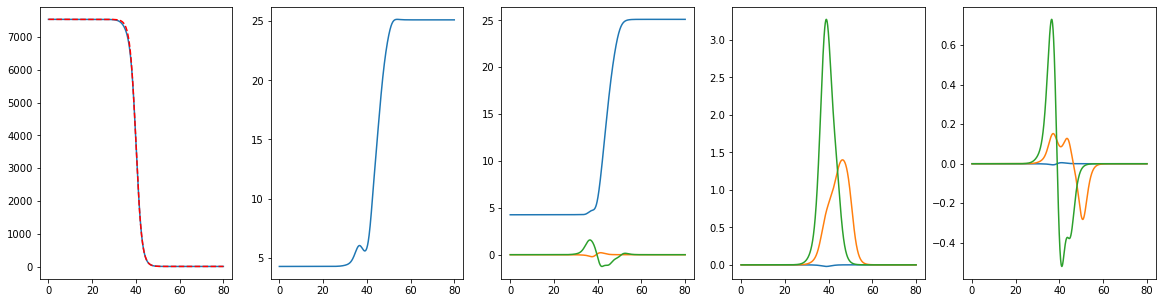

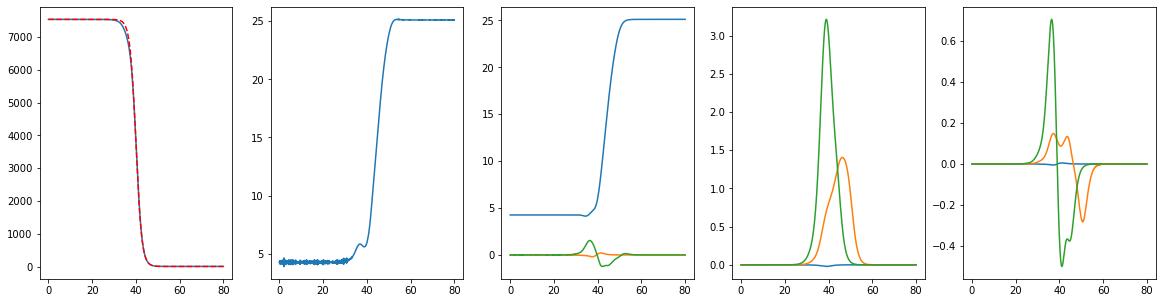

In [7]:
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=5, log=False )#.picard_iteration(tol=1.0e-5, beta=0.01, max_iter=10).anderson_mixing(tol=1.0e-9,mmax=10)# # just write after one another
# solver = DFTSolver(output=True).anderson_mixing(tol=1.0e-9,mmax=20, max_iter=10, beta=0.02)# # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit, local_flag=True)
density_init = interface.density
i = 0
while i < 3:
    interface.solve(solver, debug=True)    
    fig, axs = plt.subplots(1, 5,figsize=(20, 5), facecolor='w', edgecolor='k')
    axs[0].plot(interface.z / ANGSTROM, (interface.density/MOL*METER**3)[0,:])
    axs[0].plot(interface.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')
    # axs[0].set_ylim([7537, 7538])
    
    # axs[0].set_ylim([(interface.density/MOL*METER**3)[0,0]-0.01, (interface.density/MOL*METER**3)[0,0]+0.01])
    # axs[0].set_xlim([0, 20])

    axs[1].plot(interface.z / ANGSTROM, (interface.functional_derivative)[0,:])
    #axs[1].set_ylim([4.2605, 4.26075])

    axs[2].plot(interface.z / ANGSTROM, (interface.local_functional_derivative)[0][0,:])
    axs[2].plot(interface.z / ANGSTROM, (interface.local_functional_derivative)[1][0,:])
    axs[2].plot(interface.z / ANGSTROM, (interface.local_functional_derivative)[2][0,:])
    # axs[2].set_ylim([-0.01,.01])    
    
    for filename in glob.glob('*_grad_fpd.npy'):
        data = np.load(filename)    
        axs[3].plot(interface.z / ANGSTROM, (data)[0,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[1,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[2,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[3,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[4,:])
    # axs[3].plot(interface.z / ANGSTROM, (data)[5,:])
    # axs[3].set_ylim([-0.000001,.000001])
    
    for filename in glob.glob('*_lapl_fpd.npy'):
        data = np.load(filename)    
        axs[4].plot(interface.z / ANGSTROM, (data)[0,:])
    # axs[4].set_ylim([-0.000001,.000001])
    
    # print(data)
    fig.show()

    i = i + 1

In [29]:
# plt.plot(interface.z / ANGSTROM, (interface.density/MOL*METER**3)[0,:])
# plt.plot(interface.z / ANGSTROM, (density_init/MOL*METER**3)[0,:], 'r--')


In [30]:
# # plot initial density profile
# plt.plot(interface.z / ANGSTROM, (interface.weighted_densities)[0][1,:])
# plt.plot(interface.z / ANGSTROM, (interface.local_weighted_densities)[0][1,:], 'r--')

In [31]:
# n_comps = len(composition)
# n_wd = sum([len(x) for x in interface.weighted_densities])
# fig, axs = plt.subplots(int(n_wd/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
# i=0
# #fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()

# for j, (wds, lwds) in enumerate(zip(interface.weighted_densities, interface.local_weighted_densities)):
#     for k, (wd, lwd) in enumerate(zip(wds, lwds)):

#         axs[i].plot(interface.z / ANGSTROM, wd, 'b')
#         axs[i].plot(interface.z / ANGSTROM, lwd, 'r')
#         axs[i].set_title(f'contribution {j}, wd {k}')
#         i = i+1

# #fig.savefig(f'weighted_densities.pdf', )  


 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
 Called fn weighted_densities in GradConvolver
4
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver
 Called fn functional_derivative in GradConvolver


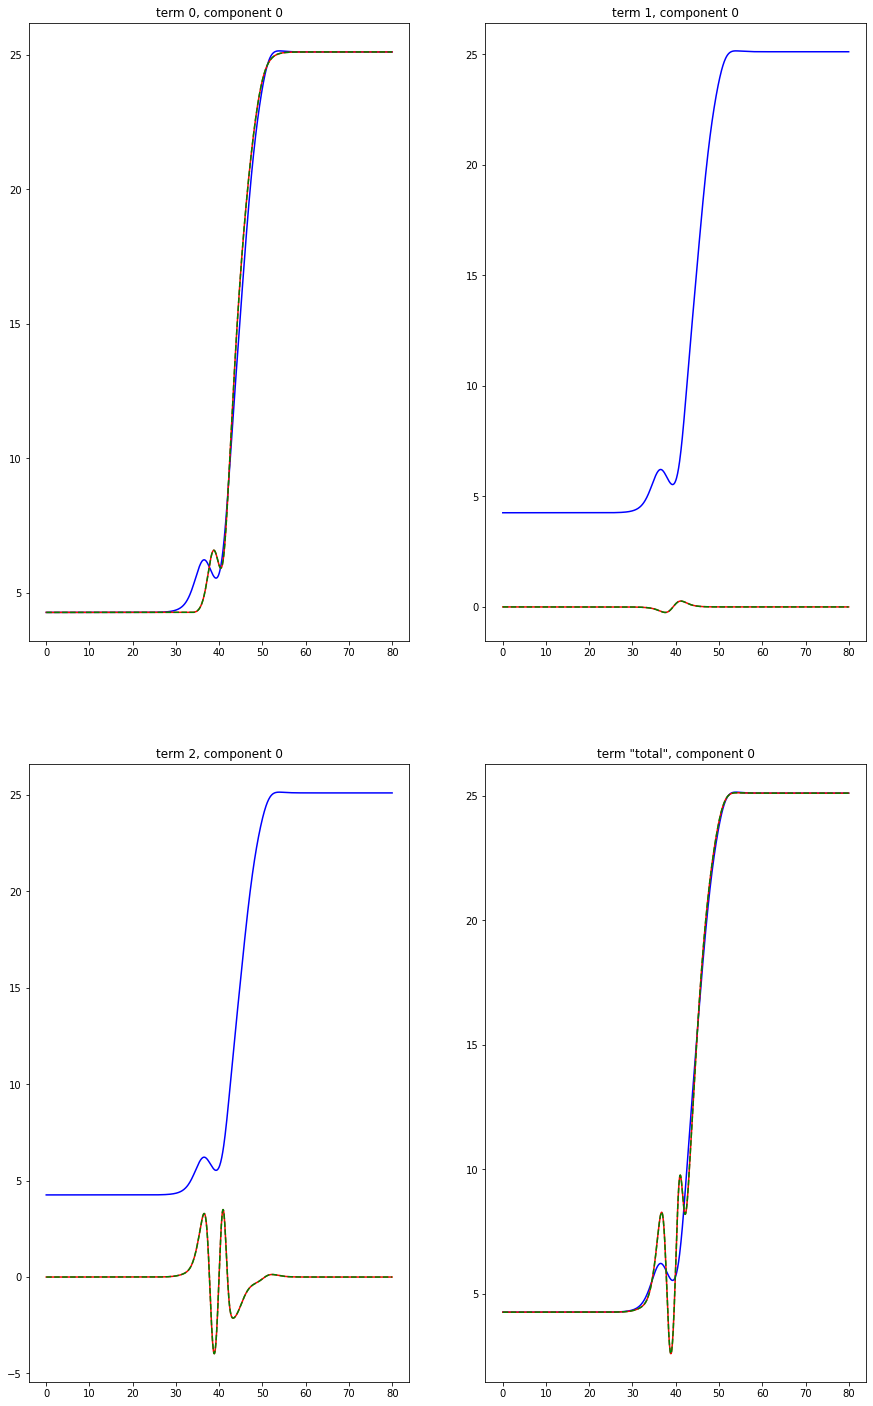

In [32]:
lfds_list = interface.local_functional_derivative
lfds_list.append(sum(interface.local_functional_derivative[0:1], interface.local_functional_derivative[2]))
lfds_list_v2 = interface.local_functional_derivative_v2
lfds_list_v2.append(sum(interface.local_functional_derivative_v2[0:1], interface.local_functional_derivative_v2[2]))


n_comps = len(composition)
n_types = sum([len(x) for x in lfds_list])
print(n_types)

fig, axs = plt.subplots(int(n_types/n_comps), n_comps,figsize=(15, 25), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, (lfds, lfds_v2) in enumerate(zip(lfds_list, lfds_list_v2)):
    for k, (fd, (lfd, lfd_v2)) in enumerate(zip(interface.functional_derivative, zip(lfds, lfds_v2))):

        axs[i].plot(interface.z / ANGSTROM, fd, 'b')
        axs[i].plot(interface.z / ANGSTROM, lfd, 'r')
        axs[i].plot(interface.z / ANGSTROM, lfd_v2, 'g--')
        if j == n_types-1: j = '"total"'
        axs[i].set_title(f'term {j}, component {k}')
        i = i+1

#fig.savefig(f'functional_derivatives.pdf', )  


Version of 8:50
w0 = [[3.0576660000000007, 2.6895279999999993],
 [5.742616691063705, 5.014246501518509],
 [135.53126057971835, 117.47491903605786],
 [84.8472962891734, 73.00515205551848],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [3.595078344122986, 3.1161190089848008],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w2 = [[1.7975391720614928, 1.5580595044924002],
 [3.375966653101143, 2.9047827052028015],
 [79.67605027197781, 68.053916577037],
 [29.927991884652585, 25.375390262606697],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w0 = [[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [22.588543429953063, 19.579153172676314],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],

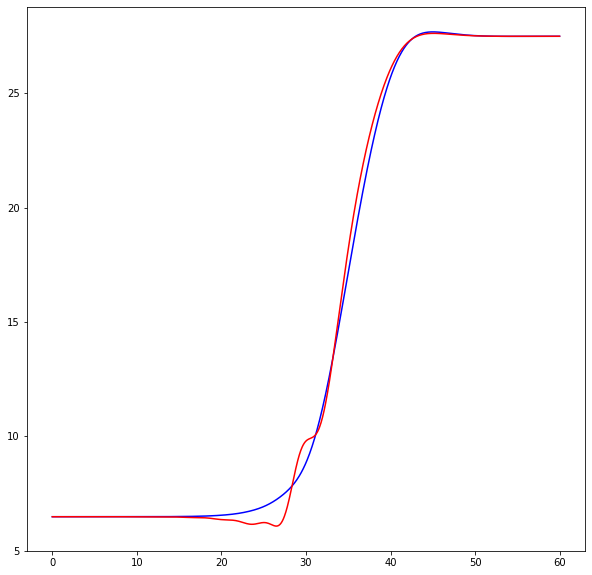

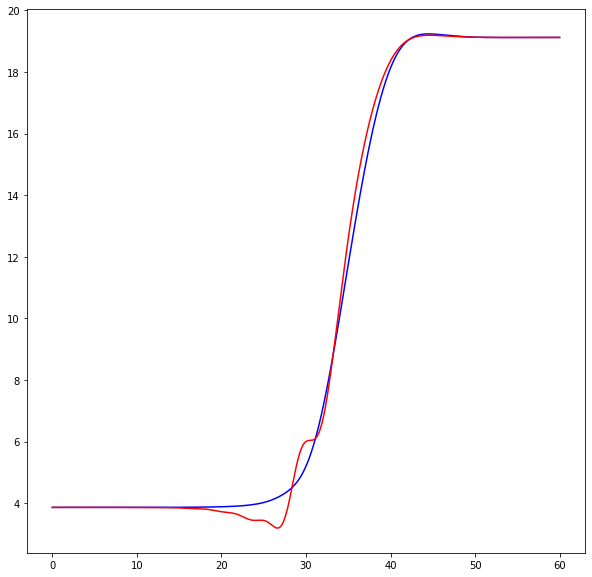

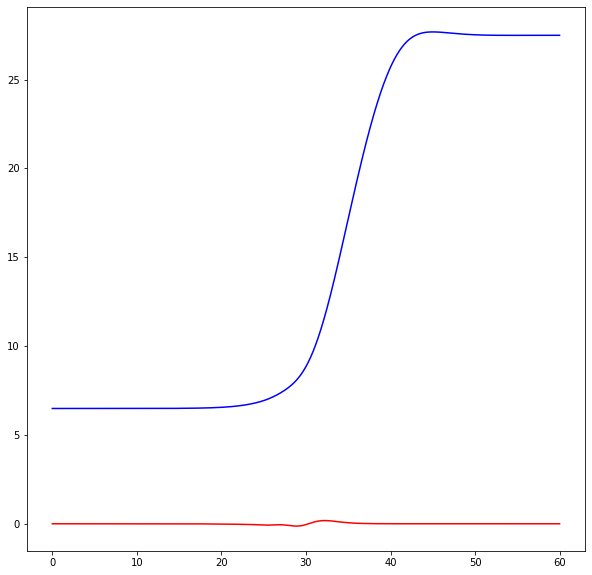

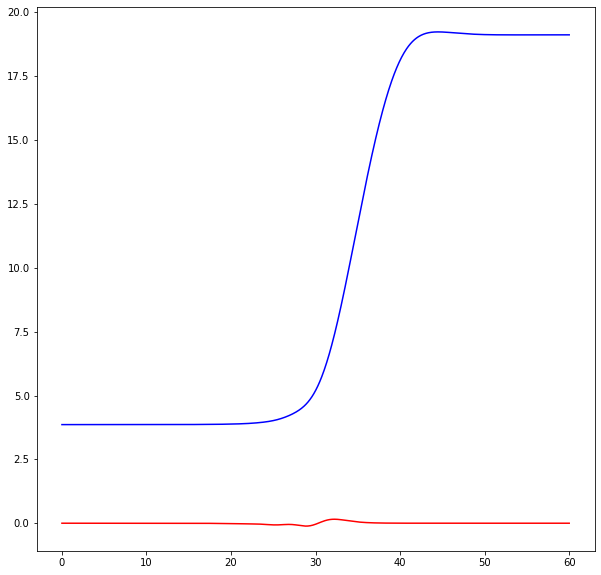

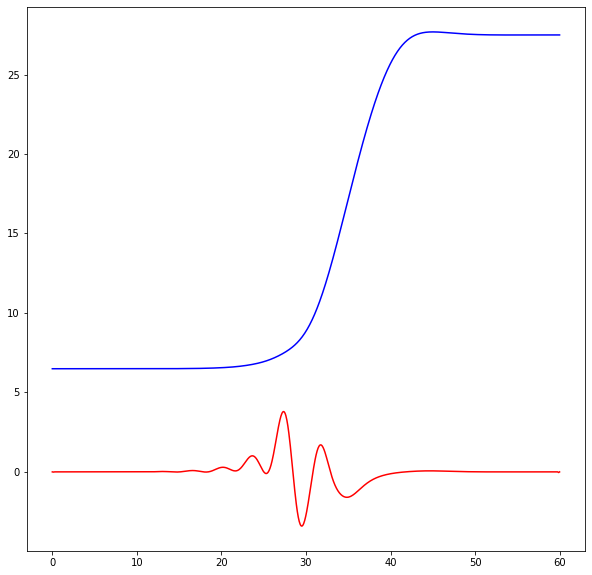

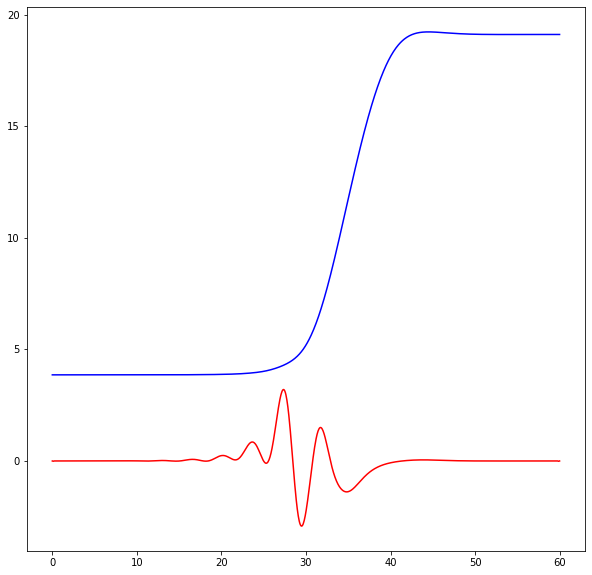

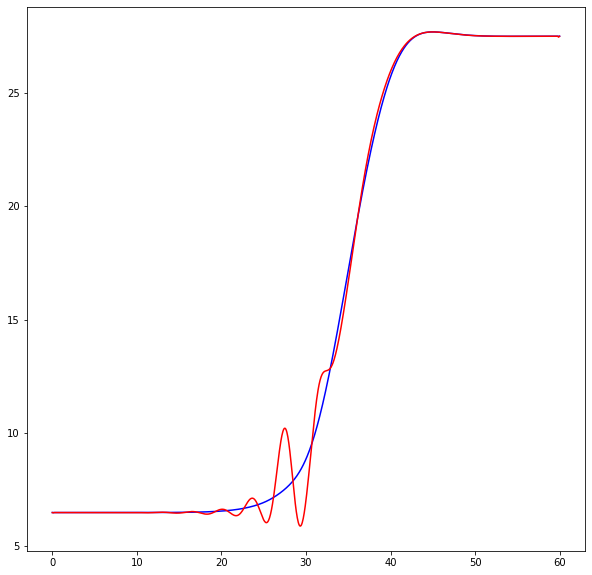

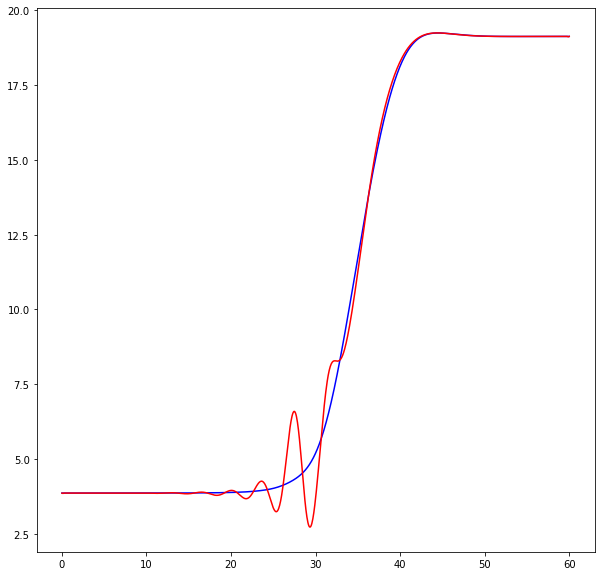

In [37]:
i = 0
i=0
lfds_list = interface.local_functional_derivative
lfds_list.append(sum(interface.local_functional_derivative))

for lfds in lfds_list:
    for fd, lfd in zip(interface.functional_derivative,lfds):
        plt.figure(figsize=(10,10))
        plt.plot(interface.z / ANGSTROM, fd, 'b')
        plt.plot(interface.z / ANGSTROM, lfd, 'r')

    #plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
    
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

Version of 8:50
w0 = [[3.0576660000000007, 2.6895279999999993],
 [5.742616691063705, 5.014246501518509],
 [135.53126057971835, 117.47491903605786],
 [84.8472962891734, 73.00515205551848],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [3.595078344122986, 3.1161190089848008],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w2 = [[1.7975391720614928, 1.5580595044924002],
 [3.375966653101143, 2.9047827052028015],
 [79.67605027197781, 68.053916577037],
 [29.927991884652585, 25.375390262606697],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w0 = [[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [22.588543429953063, 19.579153172676314],
 [84.8472962891734, 73.00515205551848]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],

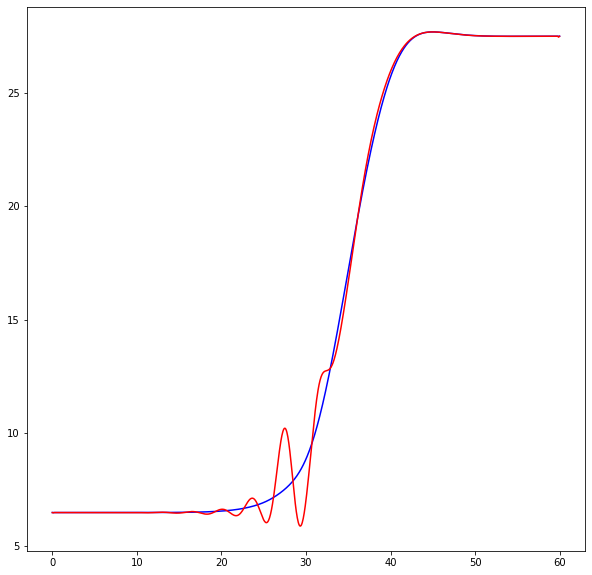

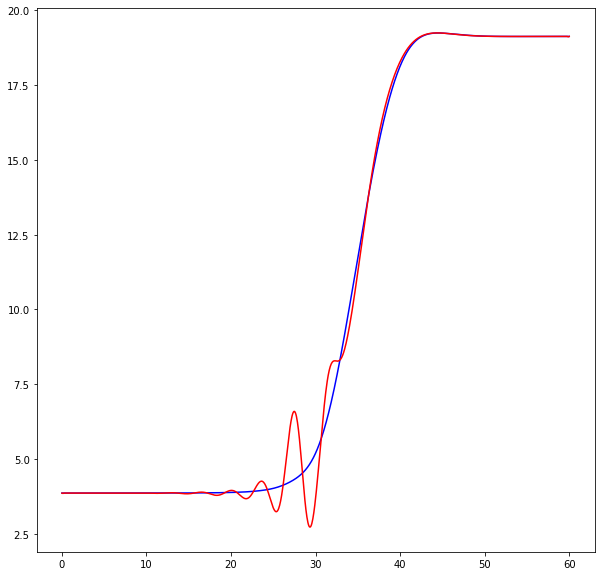

In [51]:
# plot functional derivative
i=0
for fd, lfd in zip(interface.functional_derivative, interface.local_functional_derivative):
    plt.figure(figsize=(10,10))
    plt.plot(interface.z / ANGSTROM, fd, 'b')
    plt.plot(interface.z / ANGSTROM, lfd, 'r')
    
    plt.savefig(f'functional_derivative_{i}.pdf', )  
    i=i+1
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [14]:
wd = interface.weighted_densities
plt.plot(interface.z / ANGSTROM, (wd / MOL * METER**3)[0,:])
print(len(wd))
print(wd[1].shape)

TypeError: not implemented!

## DFT Example

In [10]:
## Planar Interface 

In [11]:
# system specification
components = ['hexane', 'octane'] # ['hexane'] # 
x = 0.3
composition = np.array([x, 1-x])
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [12]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [13]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [14]:
# calculate phase equilibrium
#vle = PhaseEquilibrium.pure_t(func, temperature)
vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition)
vle


||temperature|density|molefracs|
|-|-|-|-|
|phase 1|298.15 K|2.964357865432749  mol/m³|[0.81911, 0.18089]|
|phase 2|298.15 K|6.446506873296946 kmol/m³|[0.30000, 0.70000]|


In [15]:
# calculate critical point (needed for initializiation of tanh profile)
#t_crit = State.critical_point_pure(func)[0].temperature
t_crit = State.critical_point(func, 1 * MOL *composition).temperature
t_crit

568.0769398960161 K

In [16]:
# intialize solver and interface density profile
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

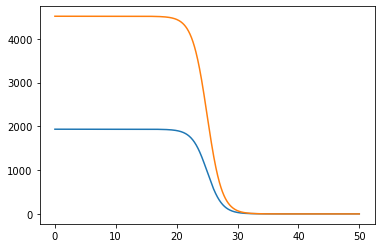

In [17]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [18]:
# solve DFT
interface.solve(solver)

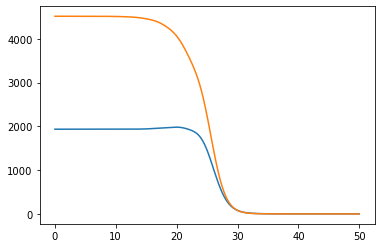

In [19]:
# plot final density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [20]:
# print surface tension
interface.surface_tension

20.13926529391086 mN/m

In [21]:
interface.equimolar_radius

2.4999964243533226 nm

# Adsorption at a wall in 1D

In [78]:
# system specification
components =  ['butane', 'pentane']
x = 0.5
composition = np.array([x, 1-x])
temperature = 250.15* KELVIN
pressure = 1 * BAR

In [79]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [80]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [81]:
# Create State 
state = State(func, temperature, pressure=pressure, molefracs=composition)

In [82]:
# create potential 
potential  = ExternalPotential.LJ93(3.0, 150.0, 0.08)
#potential  = ExternalPotential.HardWall(3.1)


In [83]:
#np.array([[5,5]*ANGSTROM,[10,10]*ANGSTROM])

In [84]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore1D(func, Geometry.Cartesian, 30*ANGSTROM, potential, 512).initialize(state)

In [85]:
#(wall_profile.density/MOL*METER**3)[0]

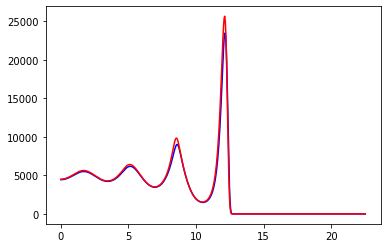

In [93]:
plt.plot(wall_profile.z / ANGSTROM,(wall_profile.density/MOL * METER **3)[0,:], 'b')
plt.plot(wall_profile.z / ANGSTROM, (wall_profile.density/MOL * METER **3)[1,:], 'r')

In [91]:
# set solver
solver = DFTSolver(output=False).picard_iteration(tol=1.0e-6, max_iter=100).anderson_mixing(tol=1.0e-8, max_iter=500, mmax=10)
# solve DFT for wall 
wall_profile.solve(solver)

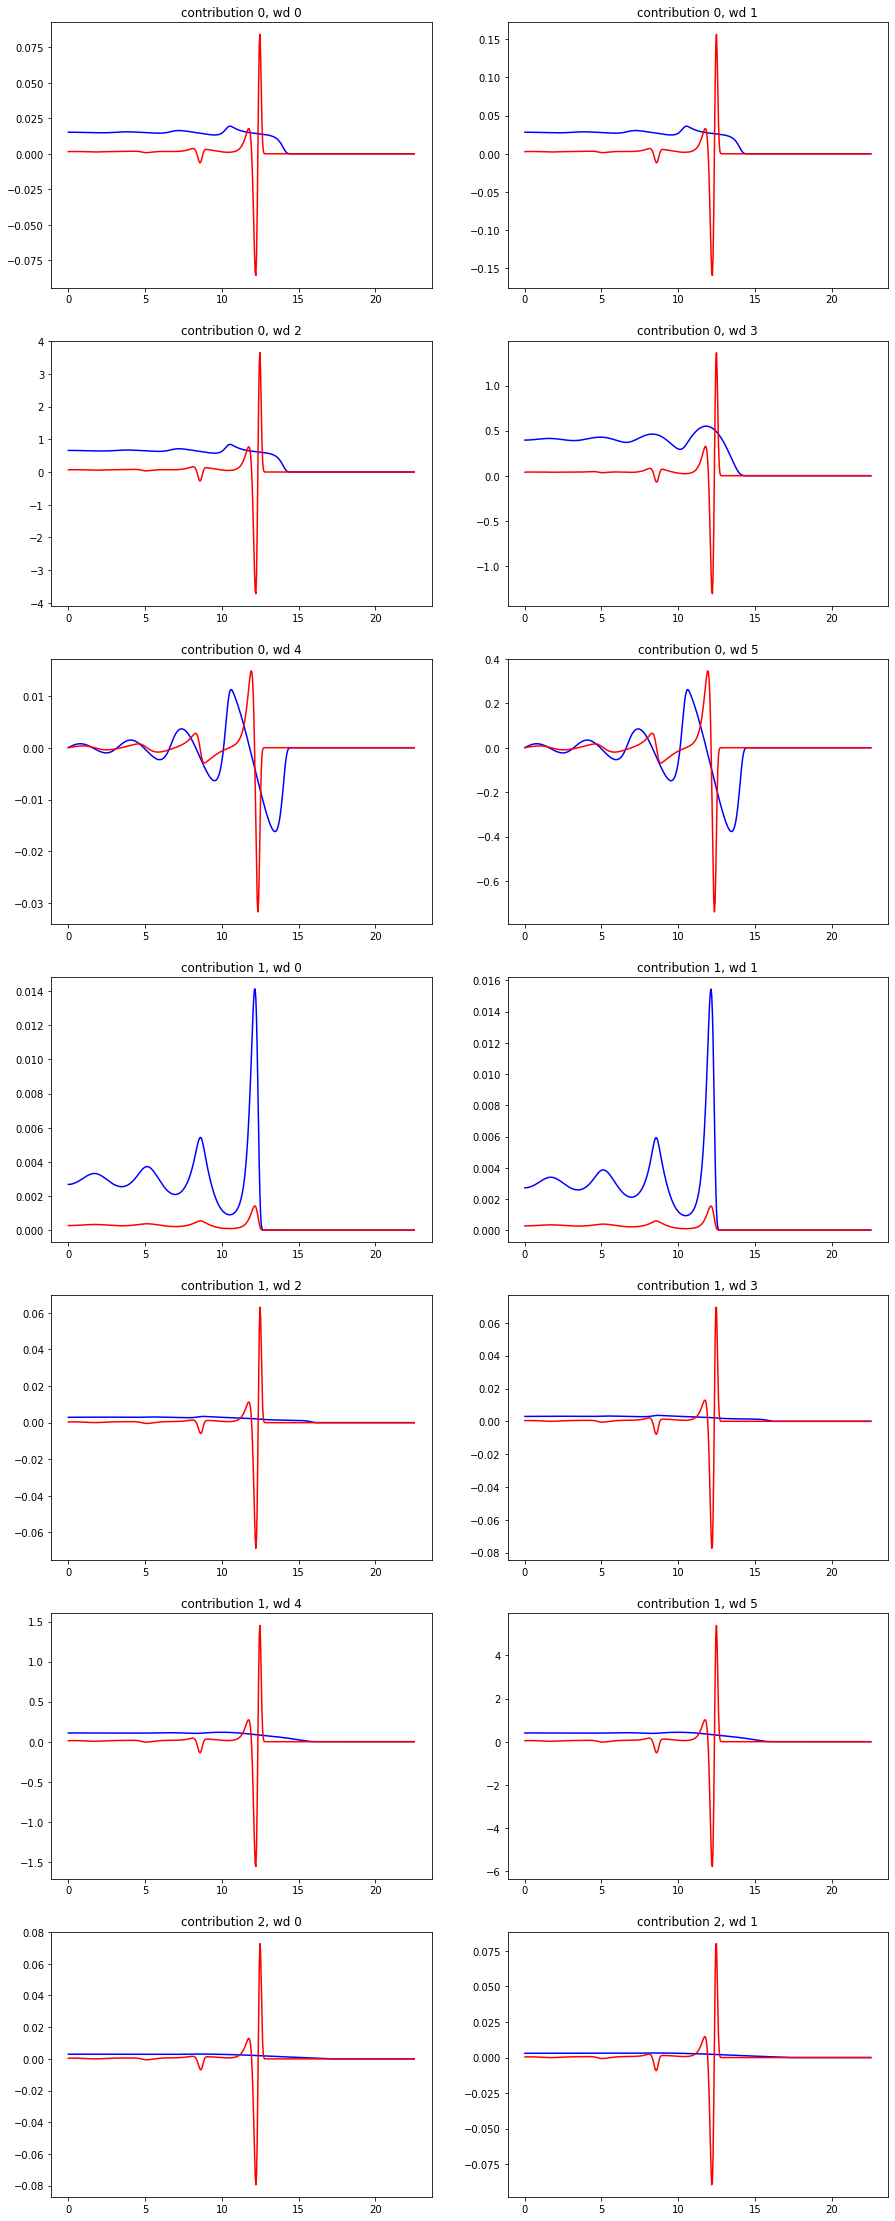

In [94]:
n_comps = len(composition)
n_wd = sum([len(x) for x in wall_profile.weighted_densities])
fig, axs = plt.subplots(int(n_wd/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, (wds, lwds) in enumerate(zip(wall_profile.weighted_densities, wall_profile.local_weighted_densities)):
    for k, (wd, lwd) in enumerate(zip(wds, lwds)):

        axs[i].plot(wall_profile.z / ANGSTROM, wd, 'b')
        axs[i].plot(wall_profile.z / ANGSTROM, lwd/10, 'r')
        axs[i].set_title(f'contribution {j}, wd {k}')
        i = i+1

#fig.savefig(f'weighted_densities.pdf', )  


Version of 8:50
w0 = [[2.331586, 2.689528],
 [4.28763691017469, 5.035654603229222],
 [99.0819230035611, 118.48016824873272],
 [60.73509765472306, 73.94422672343795],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [2.628229636177888, 3.1427840725242078],
 [60.73509765472306, 73.94422672343795]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w2 = [[1.3141148180889437, 1.5713920362621037],
 [2.416572752729538, 2.9421472990357427],
 [55.84397196746224, 69.22359344875858],
 [20.53869558476092, 25.921731025095063],
 [-0.0, -0.0],
 [-0.0, -0.0]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w0 = [[1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 0.9999999999999999],
 [16.513653833926853, 19.746694708122124],
 [60.73509765472306, 73.94422672343795]], shape=[6, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2
w1 = [[-0.0, -0.0],
 [-0.0, -0.0],
 [-0.0, -0.0],
 [-

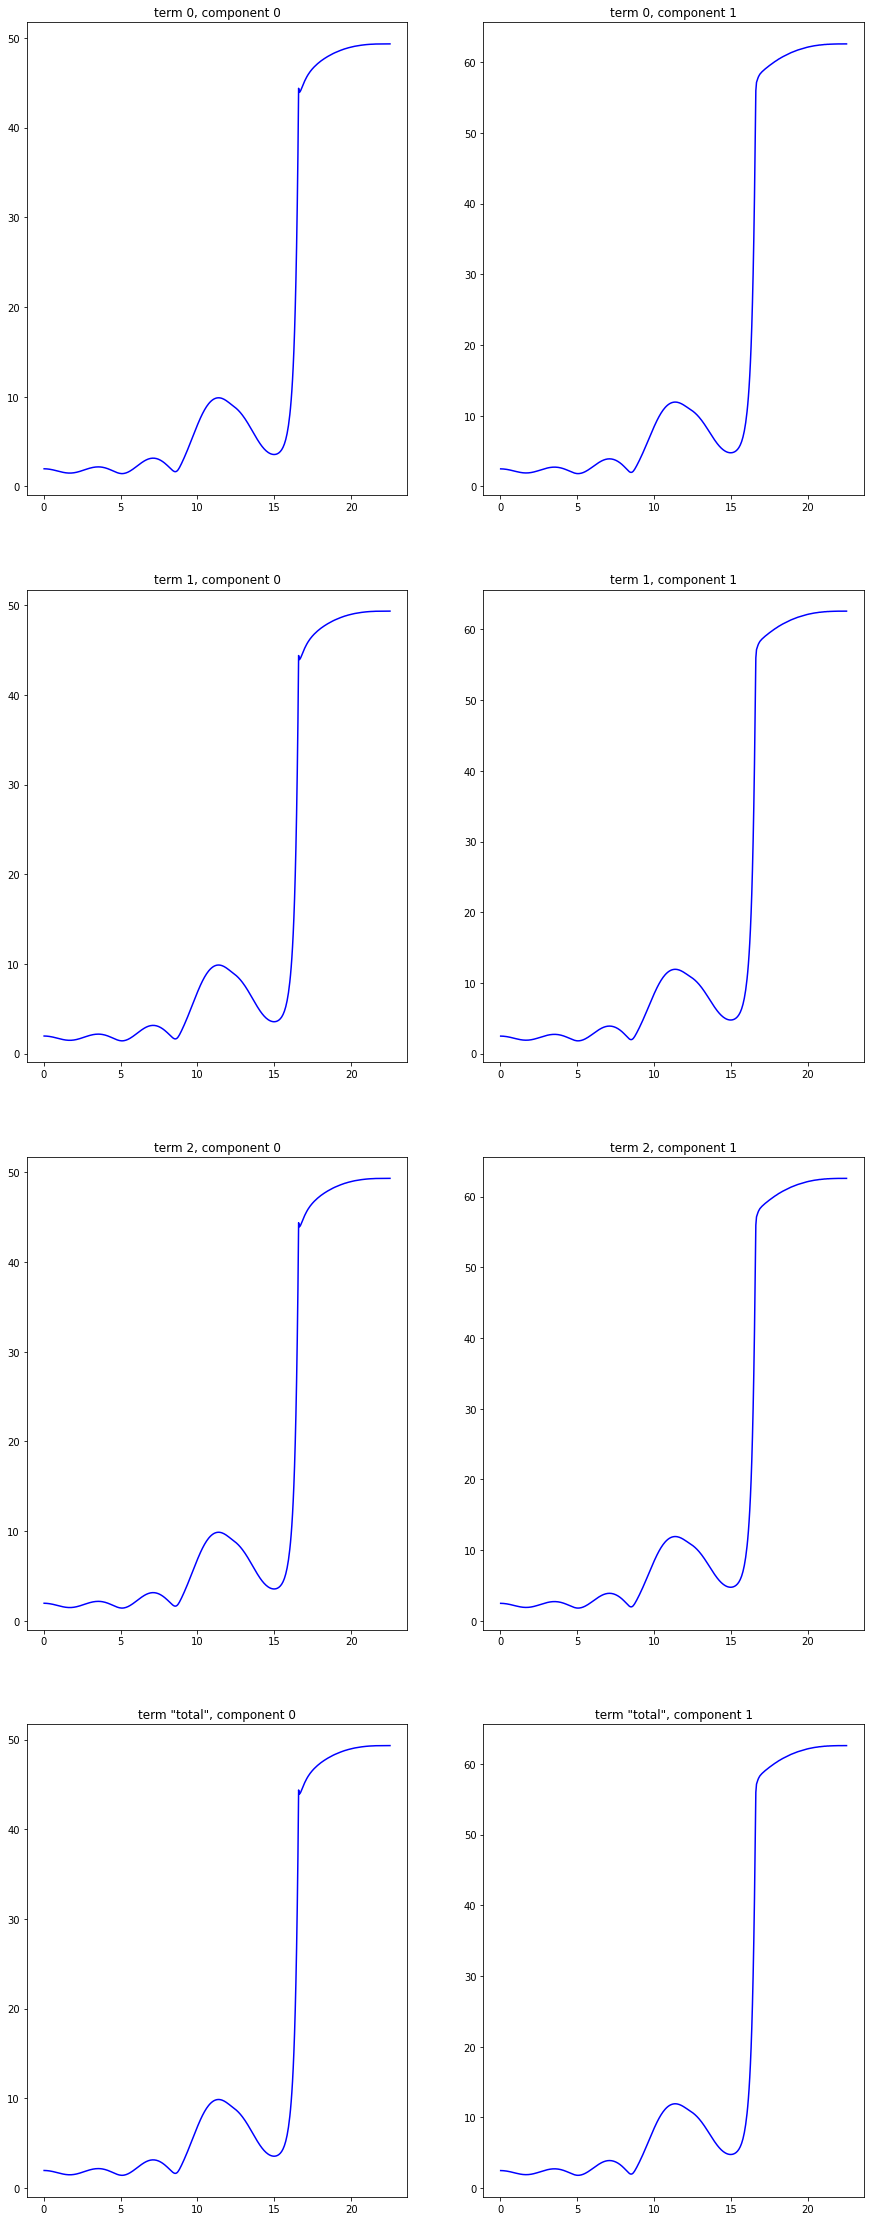

In [96]:
lfds_list = wall_profile.local_functional_derivative
lfds_list.append(sum(wall_profile.local_functional_derivative))
n_comps = len(composition)
n_types = sum([len(x) for x in lfds_list])


fig, axs = plt.subplots(int(n_types/n_comps), n_comps,figsize=(15, 40), facecolor='w', edgecolor='k')
i=0
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j, lfds in enumerate(lfds_list):
    for k, (fd, lfd) in enumerate(zip(wall_profile.functional_derivative, lfds)):

        axs[i].plot(wall_profile.z / ANGSTROM, fd, 'b')
        #axs[i].plot(wall_profile.z / ANGSTROM, lfd, 'r')
        if j == n_types/n_comps-1: j = '"total"'
        axs[i].set_title(f'term {j}, component {k}')
        i = i+1

fig.savefig(f'functional_derivatives.pdf', )  
wall_profile

solver               | iter | residual 
-------------------------------------------
Picard iteration     |    1 | 1.900411e-2 | 0.00000000000024602814176214287
Picard iteration     |    2 | 1.831382e-3 | 0.000000000004274750352979447
Picard iteration     |    3 | 4.250307e-3 | 0.0000000000022339795755648746
Picard iteration     |    4 | 2.481974e-3 | 0.00000000008653019396557015
Picard iteration     |    5 | 2.927275e-3 | 0.000000000013387153513127516
Picard iteration     |    6 | 2.249968e-3 | 0.00000000024703235354477503
Picard iteration     |    7 | 3.635263e-3 | 0.000000000053351598718656106
Picard iteration     |    8 | 2.721452e-3 | 0.0000000064322858048930995
Picard iteration     |    9 | 1.793618e-3 | 0.0000000003494042624676951
Picard iteration     |   10 | 1.789260e-3 | 0.0000000019162773703445335
Picard iteration     |   11 | 3.448593e-3 | 0.0000000009298832337076766
Picard iteration     |   12 | 2.809227e-3 | 0.00000014021139231029337
Picard iteration     |   13 | 1.738614e

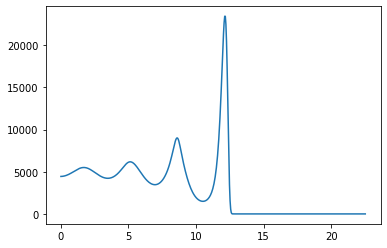

In [27]:
# plot resulting density profile
plt.plot(wall_profile.z/ANGSTROM, (wall_profile.density/MOL*METER**3)[0,:])

In [ ]:
wall_profile.density/MOL*METER**3